In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/personal-whatsapp-chats/whatsapp_chats.docx


**<div style="font-size: 50px;">Output of the Code</div>**

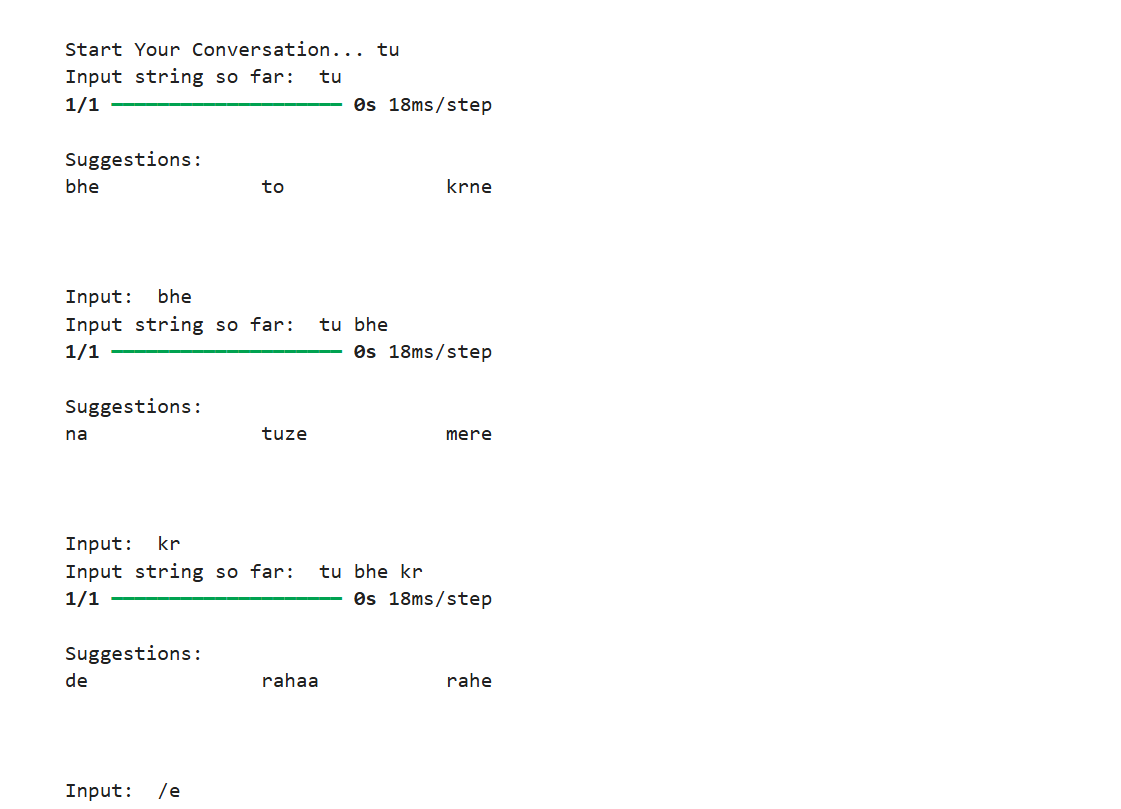

In [4]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

In [5]:
!pip install python-docx

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 1.7 MB/s eta 0:00:00a 0:00:01m


# **Step 1: Go to whatsapp and export the chat in txt format.**

In [45]:
from docx import Document

def read_docx(file_pat):
    doc = Document(file_pat)
    full_text = []
    for paragraph in doc.paragraphs:
        full_text.append(paragraph.text)
    return full_text

file_pat = '/kaggle/input/personal-whatsapp-chats/whatsapp_chats.docx'

lines = read_docx(file_pat)

In [46]:
df=pd.DataFrame(lines,)
df.drop(0,axis=0,inplace=True)

# **Step 2: Replace below name with your whatsapp name.** 

In [47]:
name='Pranav Jadhav'
name_c=name+":"
df['message'] = df[0].str.contains(name_c, case=False, na=False)
df=df[df['message']==True]
df.head()

,0,message
2,"25/02/24, 9:51 pm - Pranav Jadhav: Bol na",True
4,"25/02/24, 9:55 pm - Pranav Jadhav: Nhi re",True
5,"25/02/24, 9:55 pm - Pranav Jadhav: But Tuesday...",True
6,"25/02/24, 9:55 pm - Pranav Jadhav: Tmro nhi",True
8,"25/02/24, 9:57 pm - Pranav Jadhav: Kyu but bat...",True


In [9]:
def process(inp):
  req=inp.split(name_c)[1]
  return req
df[0]=df[0].apply(process)

In [49]:
pattern = r'[a-zA-Z]+'
df['extracted_text'] = df[0].str.findall(pattern).apply(' '.join)
df.sample(5)

,0,message,extracted_text
1895,"14/03/24, 8:39 pm - Pranav Jadhav: Kyu bd ko t...",True,pm Pranav Jadhav Kyu bd ko to bahut time hai d...
16803,"31/05/24, 7:31 pm - Pranav Jadhav: Kitne mast ...",True,pm Pranav Jadhav Kitne mast hote hai wo
15901,"27/05/24, 10:26 am - Pranav Jadhav: Chudail ut...",True,am Pranav Jadhav Chudail uth jaa kabtak sote r...
20603,"26/06/24, 11:25 pm - Pranav Jadhav: Phle nhi b...",True,pm Pranav Jadhav Phle nhi bataa skte the
16889,"31/05/24, 11:31 pm - Pranav Jadhav: 😤😤",True,pm Pranav Jadhav


***can remove the iloc to train the entire dataset.*** 

In [11]:
data_rows=int(np.floor(len(df)*0.1))
input_data=np.array(df.iloc[:data_rows,-1])

In [12]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(input_data)

In [13]:
word_dict=tokenizer.word_index
len_word_dict=len(word_dict)
len_word_dict

1486

In [14]:
sequences=tokenizer.texts_to_sequences(input_data)

In [15]:
all_inputs=[]
for i in range(0,len(sequences)):
  seq=sequences[i]
  for j in range(1,len(seq)):
    all_inputs.append(seq[:j+1])

In [16]:
len_max=max([len(i) for i in all_inputs])
len_max

40

In [17]:
pad_input=pad_sequences(all_inputs,padding='pre')
pad_input

array([[   0,    0,    0, ...,    0,   35,   12],
       [   0,    0,    0, ...,    0,    2,   60],
       [   0,    0,    0, ...,    0,   26,  723],
       ...,
       [   0,    0,    0, ..., 1485,   56, 1486],
       [   0,    0,    0, ...,   56, 1486,   67],
       [   0,    0,    0, ..., 1486,   67,    6]], dtype=int32)

In [18]:
x=pad_input[:,:-1]
y=pad_input[:,-1]

In [19]:
y.shape

(7727,)

In [20]:
x.shape

(7727, 39)

In [21]:
y=to_categorical(y,num_classes=len_word_dict+1)
emb_nums=y.shape[1]

In [24]:
model=Sequential()
model.add(Embedding(emb_nums,100))
model.add(LSTM(200))
model.add(Dense(emb_nums,activation='softmax'))

In [25]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [27]:
model.fit(x,y,epochs=50)

Epoch 1/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0364 - loss: 6.4899
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0464 - loss: 5.9437
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0438 - loss: 5.8246
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0591 - loss: 5.6217
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0943 - loss: 5.2994
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1234 - loss: 4.9700
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1578 - loss: 4.6717
Epoch 8/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1790 - loss: 4.3833
Epoch 9/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2103 - loss: 4.0686
Epoch 10/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2323 - loss: 3.8627
Epoch 11/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2768 - loss: 3.5548
Epoch 12/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

In [41]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 39, 100)        │       148,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1487)           │       298,887 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,065,163 (7.88 MB)

 Trainable params: 688,387 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,376,776 (5.25 MB)

In [28]:
def check_dict_keys(answ):
  for key,value in word_dict.items():
    if(answ==value):
      return key

# **Model is ready to use**

In [59]:
choice=True
outp=input('\nStart Your Conversation...')

st=1
while(choice):
  print("Input string so far: ",outp)
  resp=(tokenizer.texts_to_sequences([outp]))
  pad_input_test=pad_sequences(resp,padding='pre')
  resp_pred=model.predict(pad_input_test)
  output_values=np.argsort(resp_pred[0])[-3:][::-1]

  output_keys=[]
  for i in output_values:
    output_key_inde=check_dict_keys(i)
    output_keys.append(output_key_inde)

  print("\nSuggestions: ")
  print(output_keys[0],"\t\t",output_keys[1],"\t\t",output_keys[2])
  print("\n\n")

  choice=input('Input: ')
  if(choice=='/e'):
    break
  outp=outp+" "+str(choice)


Start Your Conversation... kyu


Input string so far:  kyu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Suggestions: 
ke 		 apne 		 aab





Input:  apne


Input string so far:  kyu apne
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Suggestions: 
ko 		 ke 		 unke





Input:  /e
